In [1]:
from skimage.io import imread
import numpy as np
from scipy.fftpack import dct, idct
from matplotlib import pyplot as plt


In [2]:
rootfolder = '..'

# 2D-DCT
The goal of this section is to define and use the dictionary representing the 2D-DCT.

Let $s$ a $p\times p$ patch extract from an image. We can see $s$ as a vector of dimension $M=p^2$. We can move from one representation to the other one through a `reshape` operation.


The following code defines two functions: `dct2` and `idct2`. The `dct2` function computes the coefficient $x\in\mathbb{R}^M$ of a patch $s\in\mathbb{R}^M$, while the `idct2` is the inverse function:
$$
x = \text{dct2}(s) = D^Ts, \qquad s = \text{idct2}(x) = Dx
$$

In [3]:
def dct2(s):
    # s as an array (pxp) NOT a vector (p^2)
    return dct(dct(s.T, norm='ortho').T, norm='ortho')


def idct2(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')

Useful function for plot the 2D DCT dictionary

In [4]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Set the patch size

In [5]:

p = 8 # patch size
M = p ** 2 # number of elements in the patch


Load the image and extract a patch

In [6]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255 # bring the image in [0,1] range

img.shape

(256, 256)

In [7]:
# extract a patch from the image
s_block = img[0:p,0:p]
s_block.shape

(8, 8)

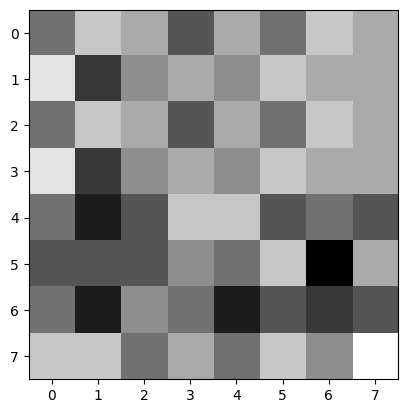

In [8]:
# unroll the patch: convert from array pxp to vector p^2
s = np.reshape(s_block,-1)

# show the patch
plt.imshow(s_block, cmap='gray')

In [9]:
print(s_block[0][0])
print(s_block[5][6])
print(s_block[6][5])
print(s_block[7][7])

0.611764705882353
0.596078431372549
0.6078431372549019
0.6313725490196078


## Compute the 2D DCT matrix (M x M)

To build the matrix corresponding to the 2D DCT we can use the `idct2` function.

In [10]:
D = np.zeros((M, M))
cnt = 0
for i in range(p):
    for j in range(p):
        a = np.zeros((p,p))
        a[i][j] = 1
        D[:, cnt] = np.reshape(idct2(a),-1)
        
        cnt = cnt + 1

Verify that D is orthonormal

In [11]:
# if the dot product == 0 and col1!=col2, then: orthogonal
# if the dot product == 1 col1!=col2, then: orthogonal
# else: not orthogonal

is_DCT_orth = True
for i in range(M):
    for j in range(M):
        dot_product = D[:, i] @ D[:, j]
        if i != j:
            is_DCT_orth = np.isclose(dot_product, 0)
        else:
            is_DCT_orth = np.isclose(dot_product, 1)

        if(is_DCT_orth == False):
            break

print(f'DCT dictionary is orthogonal: {is_DCT_orth}')

DCT dictionary is orthogonal: True


All the atoms in D can be seen as patch. Let's plot them!

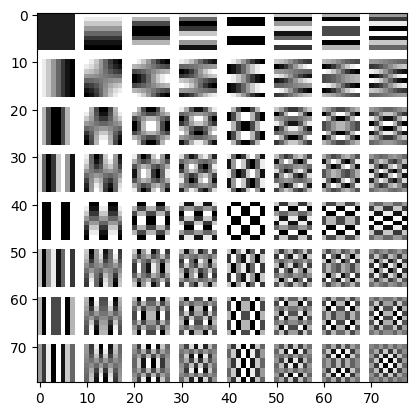

In [12]:
D_img = get_dictionary_img(D)
plt.imshow(D_img, cmap='gray')

Compute the representation w.r.t. the 2D DCT matrix

In [13]:
x = D.T @ s
x

array([ 4.92107843e+00, -7.72986509e-03,  2.58074190e-03,  1.84680302e-03,
        9.31372549e-03,  4.08061194e-03,  1.00732944e-02, -1.95161330e-03,
        1.49813998e-02, -2.80983944e-03,  2.07069587e-03,  2.83158763e-03,
       -7.66140335e-03,  7.95817184e-04, -9.01097622e-03,  1.56930069e-02,
        8.01532739e-03,  2.01352437e-03,  1.31962305e-02, -5.64950713e-03,
       -9.29627147e-03, -6.21790823e-03, -1.90131356e-03, -2.56690809e-03,
       -1.95997807e-02,  3.21006945e-04, -1.24225051e-02, -1.81450373e-03,
        3.57268182e-03, -3.56463100e-03,  2.09436973e-03, -1.13138947e-03,
        1.32352941e-02, -1.70494151e-03,  1.26209035e-03,  2.43235466e-03,
        3.43137255e-03,  1.13684505e-03, -8.48154112e-03,  2.07411193e-03,
       -8.15287792e-03,  3.61720703e-03,  4.43004880e-03, -5.59508964e-03,
       -1.00353387e-02,  1.90136817e-04,  1.47683107e-03,  5.57979227e-03,
        7.82221534e-03, -2.85481418e-03,  3.98103938e-03, -5.43604927e-03,
       -8.35279975e-03, -

## Separable 2D DCT

Build the 1D DCT matrix


In [14]:
D1 = np.zeros((p, p))
for i in range(p):
    a = np.zeros(p)
    a[i] = 1
    D1[:, i] = idct(a, norm='ortho')

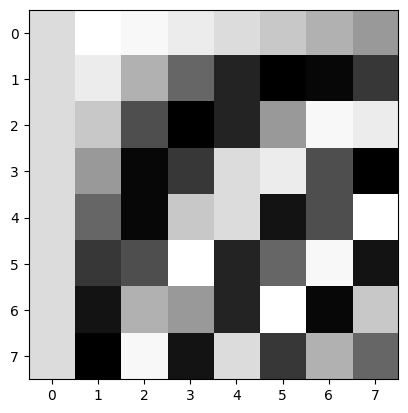

In [15]:
plt.imshow(D1, cmap='gray')

Compute the dct2 exploiting the separability. In this case do not unroll the patch: the coefficients willbe organized in a $p\times p$ matrix.

In [16]:
x_block = D1.T @ s_block @ D1
x_block

array([[ 4.92107843e+00, -7.72986509e-03,  2.58074190e-03,
         1.84680302e-03,  9.31372549e-03,  4.08061194e-03,
         1.00732944e-02, -1.95161330e-03],
       [ 1.49813998e-02, -2.80983944e-03,  2.07069587e-03,
         2.83158763e-03, -7.66140335e-03,  7.95817184e-04,
        -9.01097622e-03,  1.56930069e-02],
       [ 8.01532739e-03,  2.01352437e-03,  1.31962305e-02,
        -5.64950713e-03, -9.29627147e-03, -6.21790823e-03,
        -1.90131356e-03, -2.56690809e-03],
       [-1.95997807e-02,  3.21006945e-04, -1.24225051e-02,
        -1.81450373e-03,  3.57268182e-03, -3.56463100e-03,
         2.09436973e-03, -1.13138947e-03],
       [ 1.32352941e-02, -1.70494151e-03,  1.26209035e-03,
         2.43235466e-03,  3.43137255e-03,  1.13684505e-03,
        -8.48154112e-03,  2.07411193e-03],
       [-8.15287792e-03,  3.61720703e-03,  4.43004880e-03,
        -5.59508964e-03, -1.00353387e-02,  1.90136817e-04,
         1.47683107e-03,  5.57979227e-03],
       [ 7.82221534e-03, -2.854814

In [17]:
print(s.shape)
print(s_block.shape)
print()
print(x.shape)
print(x_block.shape)

(64,)
(8, 8)

(64,)
(8, 8)


Check if the coefficient computed using the two methods are equal

In [18]:
is_coeff_equal = np.all(np.abs(x_block.reshape(-1) - x) < 1e-10)
print(f'The two vectors of coefficients are the same: {is_coeff_equal}')

The two vectors of coefficients are the same: True


# JPEG Compression

The goal of this section is to implement the compression algorithm at the core of JPEG compression.

The idea is to divide the image in $8\times 8$ non overlapping patches and to compress each patch separately. More precisely, given a patch $s$ and its coefficient vector $x$ w.r.t. the DCT basis, we keep only the coefficients having a magnitude larger than a compression threshold $\tau$. In practice, a larger $\tau$ yields a greater compression ratio, where we define the compression ratio as
$$
\text{Comp Ratio} = 1 - \frac{\#\text{Non zero coefficients}}{\#\text{pixel in the image}}
$$

The larger the compression ratio, the smaller the amount of memory we need to store the compressed image.

Another figure of merit we use to evaluate the compression is the PSNR:
$$
\text{PSNR} = 10\log_{10}\frac{1}{\text{MSE}(Y, \widehat Y)}
$$
where $y$ is the original, uncompressed image, $\widehat y$ is the compressed image, and $\text{MSE}$ is the Mean Squared Error


In [19]:
# Set the threshold for the compression
threshold = 0.5 #0.5

# Initialize the compressed image and the number of nonzero coefficients
img_comp = np.zeros_like(img)
nnz_coeff = 0

# Process the image patchwize
for i in range(0, img.shape[0], p):
    for j in range(0, img.shape[1], p):
        # extract the patch
        s = img[i:i+p, j:j+p]

        # compute the representation w.r.t. the 2D DCT dictionary
        x = dct2(s) 
        # x = D1.T @ s
        
        # perform the hard thresholding (do not perform HT on the DC!)
        x_HT = np.where(np.abs(x) >= threshold, x, 0)
        x_HT[0,0] = x[0,0] # leave original value of DC
        
        # reconstruct the patch
        s_hat = idct2(x_HT)
        # s_hat = D1 @ x_HT
    
        # put the compressed patch into the compressed image
        img_comp[i:i+p, j:j+p] = s_hat

        # update the total number of nonzero coefficient
        nnz_coeff = nnz_coeff + np.count_nonzero(x_HT)

Compute the PSNR

In [20]:
mse = np.mean((img-img_comp)**2)
psnr = 10*np.log10(1/mse)

Compute the compression ratio

In [21]:
print(nnz_coeff)
comp_ratio = 1 - (nnz_coeff/img.size)
comp_ratio

1580


0.97589111328125

Show the original image and the compressed one:

Text(0.5, 1.0, 'Compressed Image,\nPSNR = 23.95, compression_ratio = 0.98')

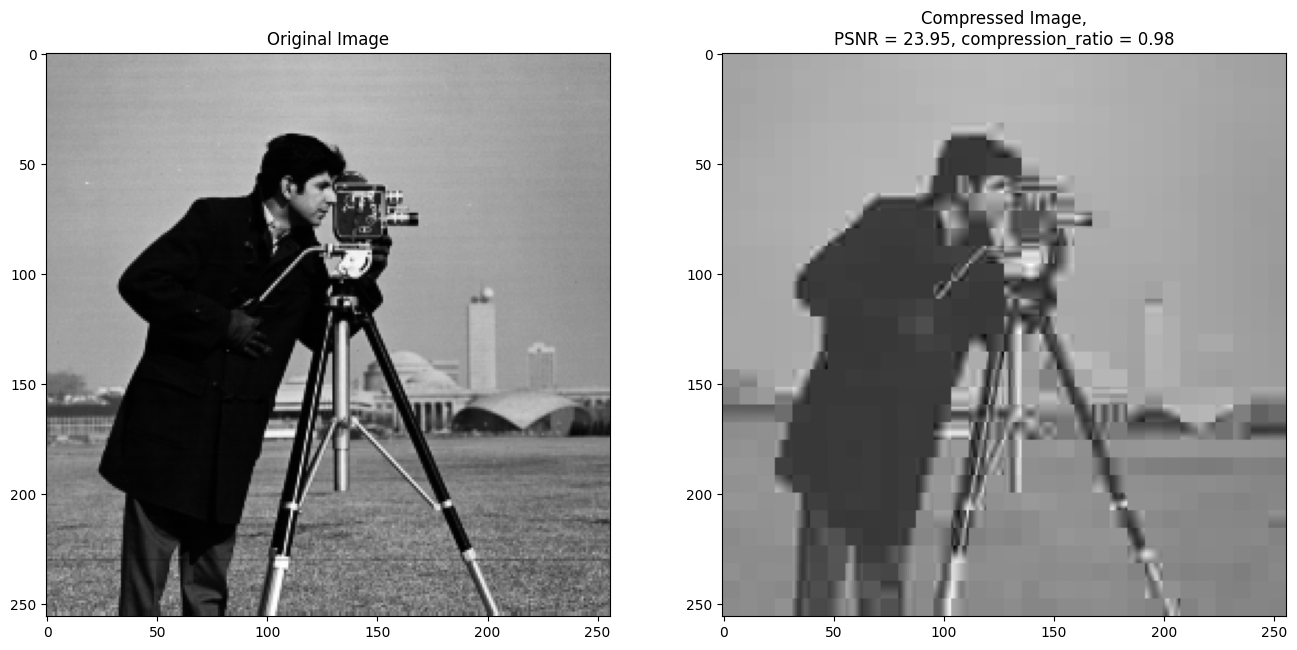

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(img_comp, cmap='gray')
ax[1].set_title(f'Compressed Image,\nPSNR = {psnr:.2f}, compression_ratio = {comp_ratio:.2f}')


# Denoising

The goal of this section is to implement a simple denoising algorithm based on the 2D DCT. Given a noise free image $Y$, we observe a noisy version $S$:
$$
S = Y + \eta
$$
where $\eta\sim N(0, \sigma^2)$ denotes white Gaussian noise.

Our goal is to compute and estiamte $\widehat Y$ of the original image $Y$. To evaluate the performance of the denoising algorithm we use again the PSNR:
$$
\text{PSNR} = 10\log_{10}\frac{1}{\text{MSE}(Y, \widehat Y)}
$$

Load the image and rescale it in $[0,1]$

In [23]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [24]:
sigma_noise = 20/255
# np.random.seed(1)
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [25]:
mse = np.mean((img-noisy_img)**2)
psnr_noisy = 10*np.log10(1/mse)
psnr_noisy

np.float64(22.07784349926022)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.08')

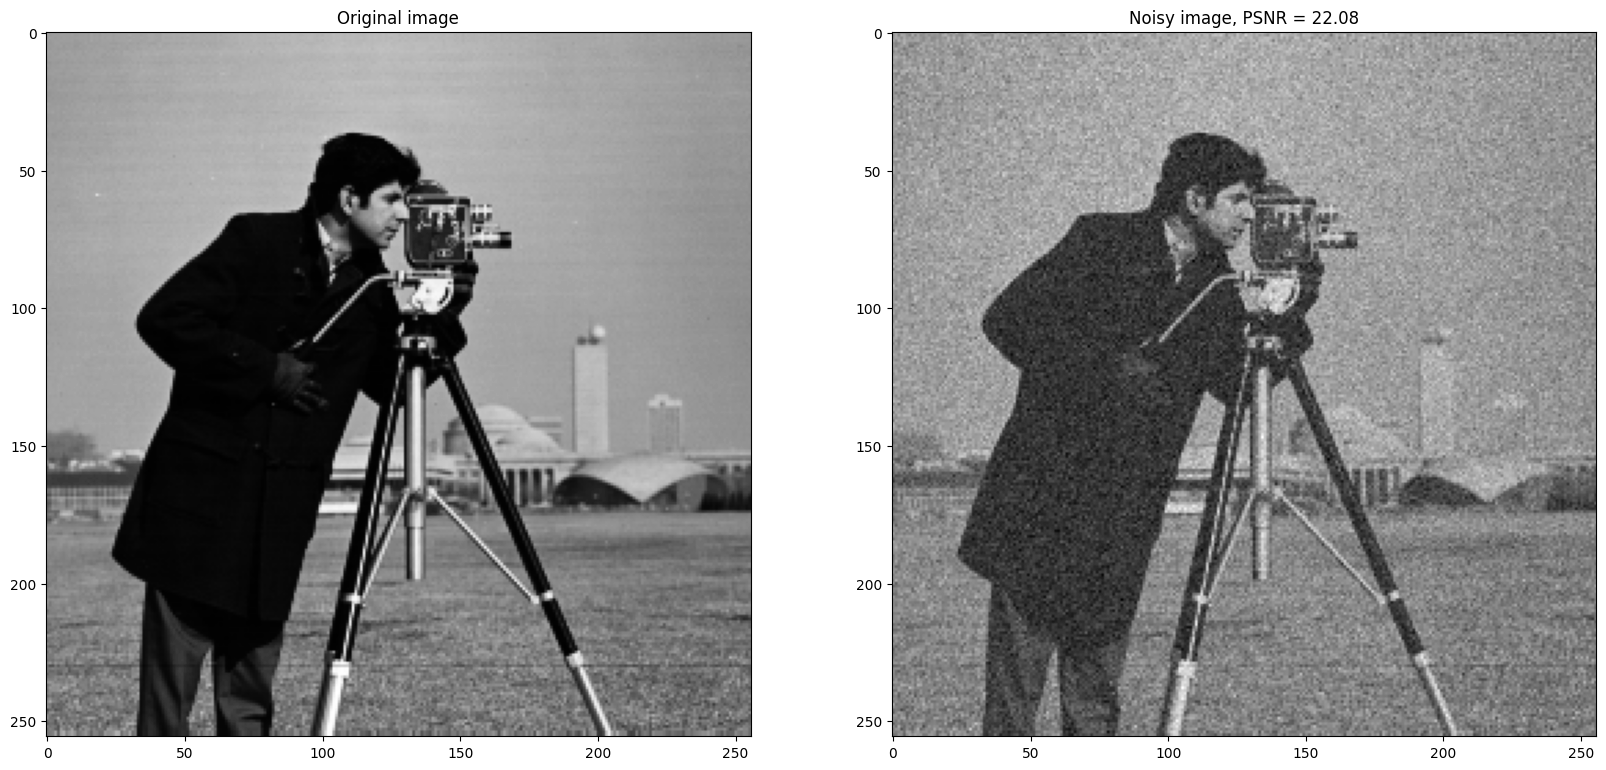

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

Denoising: set parameters and initialize the variables

In [27]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise # Donoho says: sigma * sqrt(2*log10(p^2))


Perform the denoising pathwise

In [28]:
for i in range(0, imsz[0] - p + 1, p):
    for j in range(0, imsz[1] - p + 1, p):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p]

        # compute the representation w.r.t. the 2D DCT dictionary
        x = dct2(s)

        # perform the hard thresholding (do not perform HT on the DC!)
        x_HT = np.where(np.abs(x) >= tau, x, 0)
        x_HT[0,0] = x[0,0] # leave original value of DC

        # perform the reconstruction
        s_hat = idct2(x_HT) 
        
        # put the compressed patch into the compressed image using the computed weight
        img_hat[i:i+p, j:j+p] = s_hat


Compute the psnr of the estimated image

Text(0.5, 1.0, 'Noisy image, PSNR = 26.11')

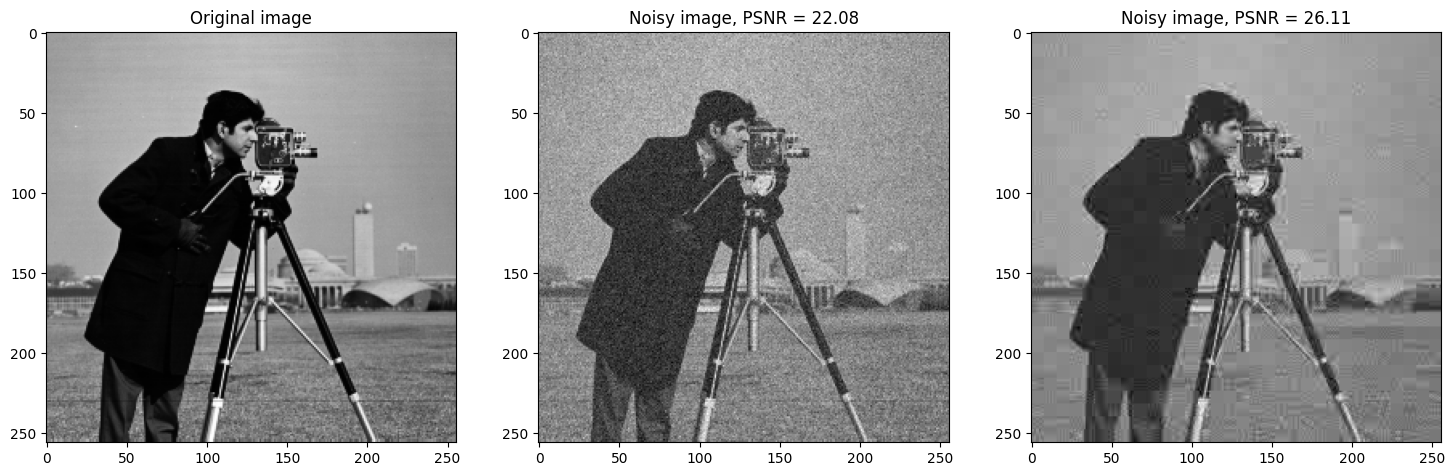

In [29]:
mse = np.mean((img-img_hat)**2)
psnr_hat = 10*np.log10(1/mse)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

ax[2].imshow(img_hat, cmap='gray')
ax[2].set_title(f'Noisy image, PSNR = {psnr_hat:.2f}')

